In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,12)

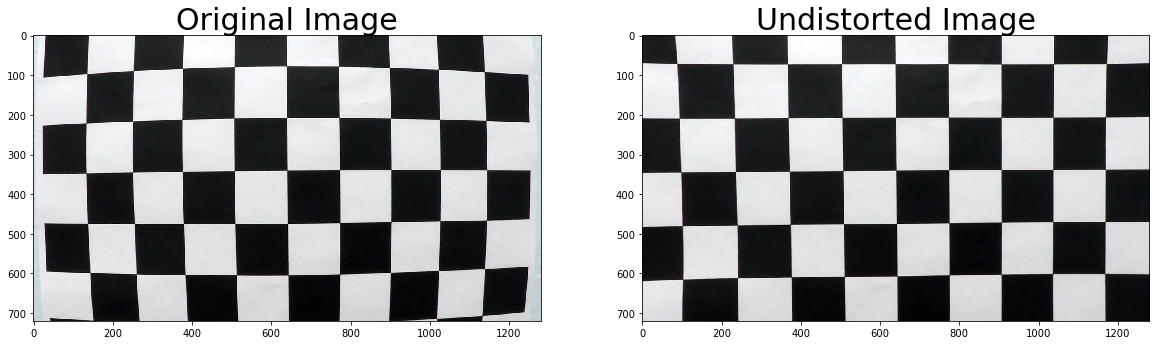

In [2]:
##### Camera Calibration. Calculate camera matrix "mtx" and distortion coefficients "dist" for later use.

# prepare object points of a chessboard with 9x6 inner corners
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = []
imgpoints = []

# go through all the chessboard images for calibration
for idx in range(1, 21):
    inputfile = 'camera_cal/calibration' + str(idx) + '.jpg'
    img = cv2.imread(inputfile)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corner
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # if found, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # draw the corners in original image, and save for visual check
        #cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #tmpfile = 'tmp' + str(idx) + '.jpg'
        #cv2.imwrite(tmpfile, img)

# calculate camera matrix and distortion coefficients
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Verify the undistortion result by comparing image before and after
# Use an image which failed to find chessboard corner (so consider as a new picture)
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

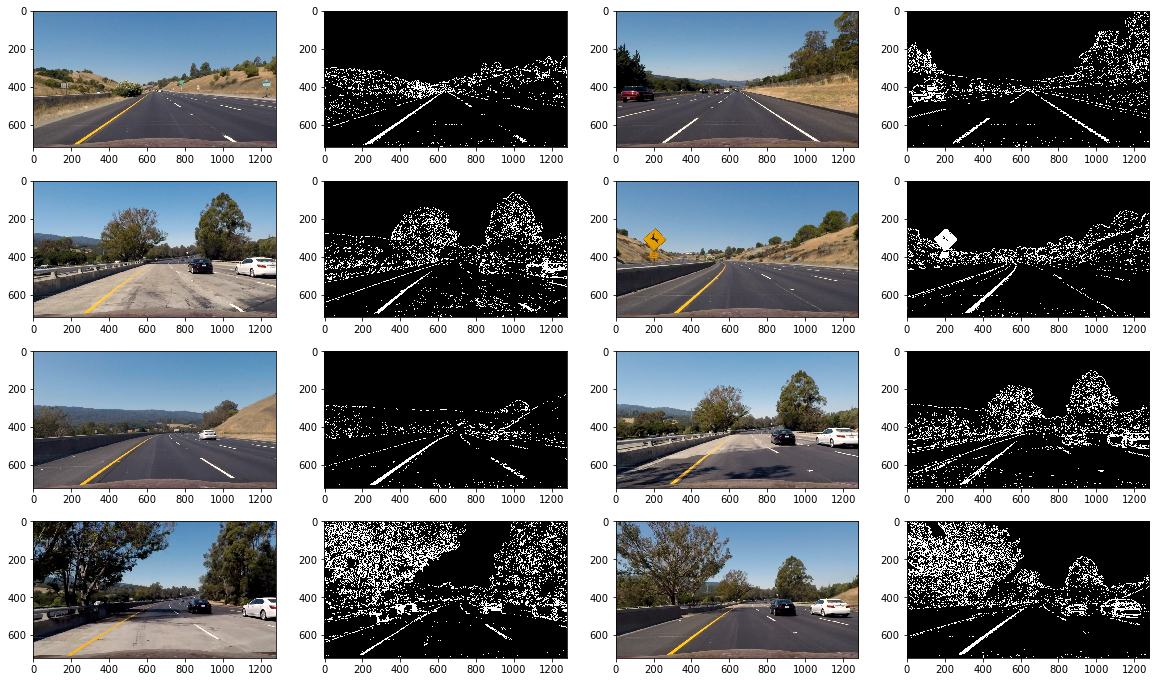

In [3]:
##### Define functions to create thresholded binary image.
##### Tune parameters by verifying on the test images.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag > mag_thresh[0]) & (gradmag < mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# fine-tune parameters
def threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ksize = 3
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 150))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(10, 150))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.9, 1.3))
    s_binary = hls_select(image, thresh=(180,255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    return combined

# verify results with 8 test images
fig = plt.figure()
image_file_list = sorted(['test_images/' + s for s in os.listdir("test_images/") if s.endswith('jpg')])
for i in range(8):
    fig.add_subplot(4,4,i*2+1)
    image = cv2.imread(image_file_list[i])
    image = cv2.undistort(image, mtx, dist, None, mtx)
    combined = threshold(image)
    pltimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(pltimage)
    fig.add_subplot(4,4,i*2+2)
    plt.imshow(combined, cmap='gray')
    filename = 'threshold' + str(i) + '.jpg'
    combined = combined*255
    cv2.imwrite(filename, combined)

(1280, 720)


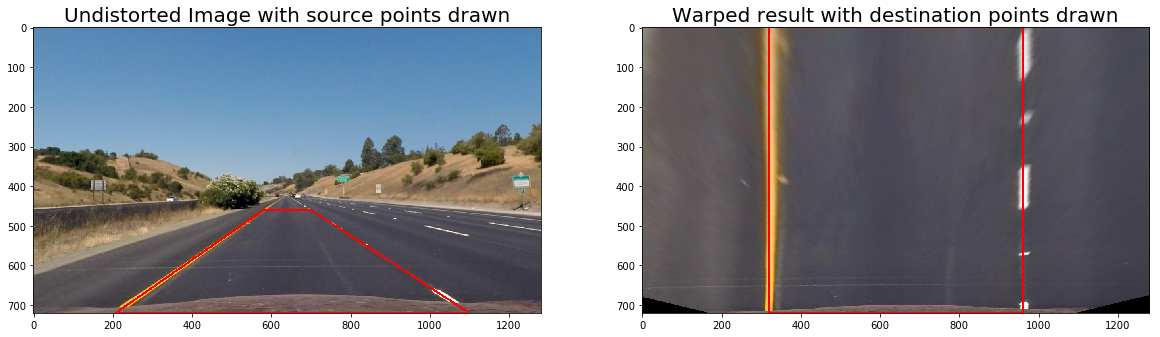

In [4]:
##### Carefully choose source and destination points for perspective transform
img = plt.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
undist_size = (undist.shape[1], undist.shape[0])
print(undist_size)
src = np.float32([[581,460],[207,720],[1100,720],[700,460]])
dst = np.float32([[320,0],[320,720],[960,720],[960,0]])

def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped = warper(undist, src, dst)

# draw pictures to show the perspective transform results
pts = np.array([[581,460],[207,720],[1100,720],[700,460]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(undist,[pts],True,(255,0,0), 4)
wpts = np.array([[320,0],[320,720],[960,720],[960,0]], np.int32)
wpts = wpts.reshape((-1,1,2))
cv2.polylines(warped,[wpts],True,(255,0,0), 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped result with destination points drawn', fontsize=20)

(1280, 720)


True

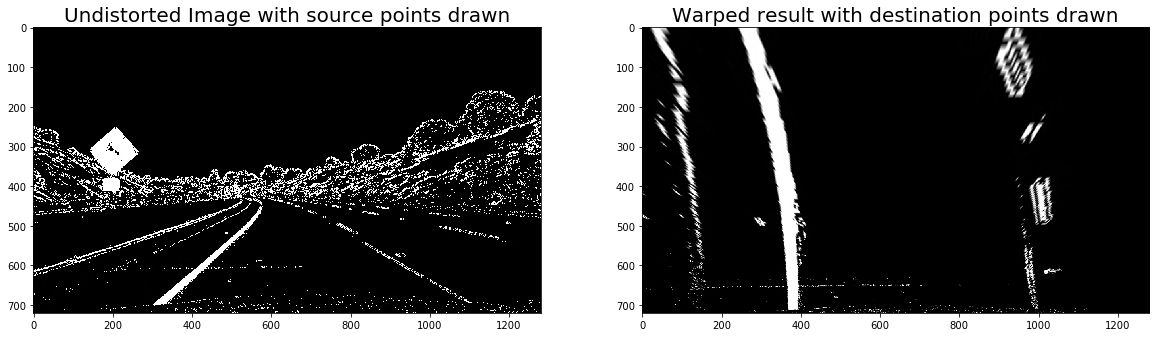

In [5]:
##### verify perspective transform with curved lane
img = plt.imread('threshold3.jpg')
img_size = (img.shape[1], img.shape[0])
print(img_size)
src = np.float32([[581,460],[207,720],[1100,720],[700,460]])
dst = np.float32([[320,0],[320,720],[960,720],[960,0]])

def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped = warper(img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped result with destination points drawn', fontsize=20)
cv2.imwrite('warped.jpg', warped)

(720, 0)

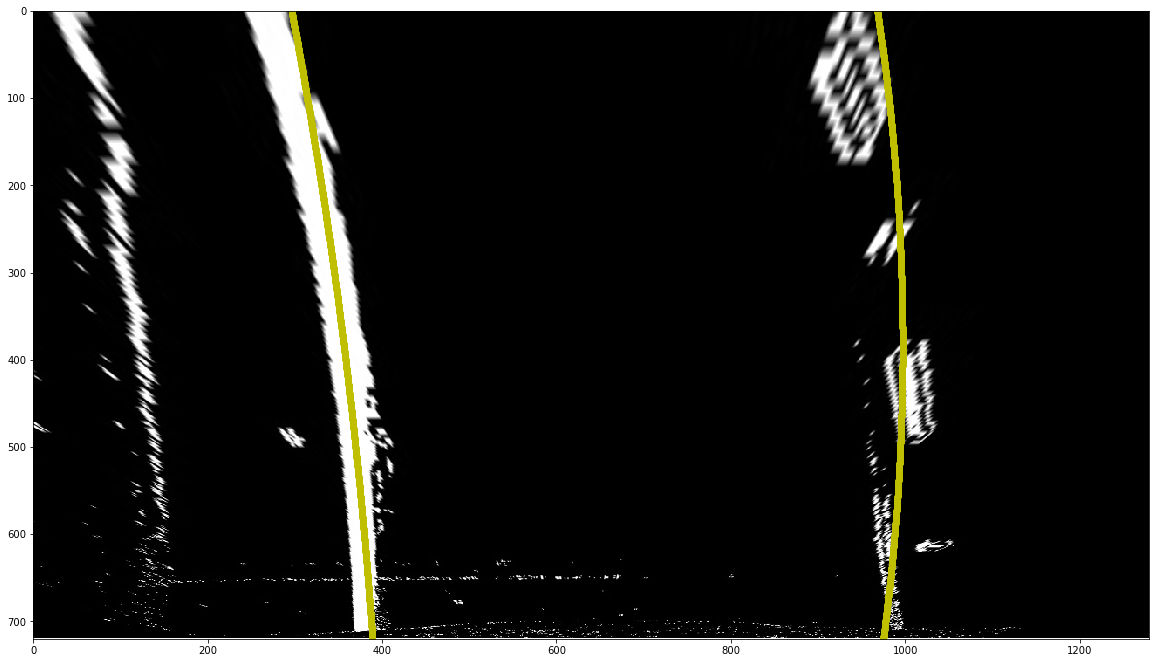

In [11]:
##### function to read a binary warped image, return value for ploting lines, also return curve radius
def find_line(binary_warped):
    global left_fit, right_fit

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if left_fit == []: ## for first image, use sliding window and fit a polynomial
        margin = 120 
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram as starting point
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 12
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Step through the windows one by one, using a smaller margin each time
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - (margin-window*window)
            win_xleft_high = leftx_current + (margin-window*window)
            win_xright_low = rightx_current - (margin-window*window)
            win_xright_high = rightx_current + (margin-window*window)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each lane line
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    else: ## if previous lines exist, just search around them, needn't sliding window
        margin = 80 
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each lane line, and smooth with previous lane line
        left_fit = left_fit*0.95 + np.polyfit(lefty, leftx, 2)*0.05
        right_fit = right_fit*0.95 + np.polyfit(righty, rightx, 2)*0.05
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # calculate curve radius in meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = (left_curverad + right_curverad) / 2
    # Calculate the distance to the center
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = image.shape[1]//2
    dx = (veh_pos - middle)*xm_per_pix # Positive if on right, Negative on left
    return ploty, left_fitx, right_fitx, curverad, dx

# Assuming you have created a warped binary image called "binary_warped"
left_fit = []
right_fit = []
binary_warped = plt.imread('warped.jpg')
ploty, left_fitx, right_fitx, curverad, dx = find_line(binary_warped)

plt.imshow(binary_warped, cmap='gray')
plt.plot(left_fitx, ploty, 'yo')
plt.plot(right_fitx, ploty, 'yo')
plt.xlim(0, 1280)
plt.ylim(720, 0)

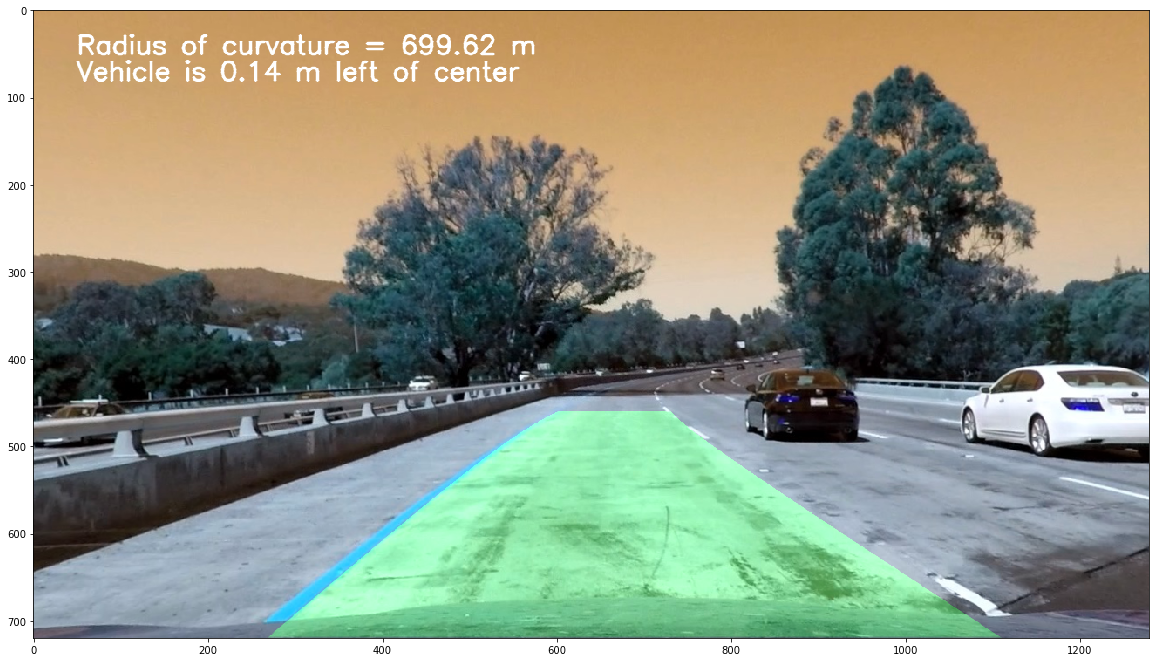

In [12]:
# global variables
left_fit = []
right_fit = []

def image_pipeline(image):
    global mtx, dist
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    thresh = threshold(undist)
    src = np.float32([[581,460],[207,720],[1100,720],[700,460]])
    dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    warped = warper(thresh, src, dst)
    ploty, left_fitx, right_fitx, curverad, dx = find_line(warped)
    # fill green color in the lane
    lanewarp = np.zeros_like(warped).astype(np.uint8)
    lanewarp = np.dstack((lanewarp,lanewarp,lanewarp))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(lanewarp, np.int_([pts]), (0,255, 0))    
    # reverse perspective transform
    lane = warper(lanewarp, dst, src)
    lane.astype(int)
    output = cv2.addWeighted(undist, 1, lane, 0.3, 0)
    # add text
    radtext = 'Radius of curvature = %.2f m'%(curverad)
    cv2.putText(output, radtext,(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    dxtext = 'Vehicle is %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right')
    cv2.putText(output, dxtext, (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return output

image = cv2.imread('test_images/test1.jpg')
newimage = image_pipeline(image)
plt.imshow(newimage)

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [14]:
left_fit = []
right_fit = []
output = 'output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(19,25)
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [03:24<00:00,  6.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 6min 47s, sys: 1.3 s, total: 6min 48s
Wall time: 3min 24s


In [15]:
left_fit = []
right_fit = []
output = 'output_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,4)
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


100%|██████████| 485/485 [01:17<00:00,  6.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

CPU times: user 2min 35s, sys: 504 ms, total: 2min 36s
Wall time: 1min 17s
